# Calculating properties in the native model grid using xgcm

For maximum accuracy it is always preferrable to calculate properties in the closest way possible to the model code, which at the least means executing calculations on the native grid. For comparison you can then regrid properties afterwards. To demonstrate how to do this we now calculate the meridional sea surface temperature gradient for the SOSE output.

For these sort of calculations we use [xgcm](https://xgcm.readthedocs.io/en/latest/index.html), which helps us to deal with the staggered grids that models use:

In [27]:
from xgcm import Grid

in order to work with xgcm we have to create a `Grid` object which 'understands' which coordinates of a dataset are representing the various staggered grid positions.

But first we need to check quickly how the model grid is designed. 

In [28]:
print(ds_model.XC[0] < ds_model.XG[0])
print(ds_model.YC[0] < ds_model.YG[0])

<xarray.DataArray ()>
array(False)
Coordinates:
    XC       float32 0.083333336
    XG       float32 5.551115e-17
<xarray.DataArray ()>
array(False)
Coordinates:
    YC       float32 -77.87497
    YG       float32 -77.9583


We can see that for the first datapoint of the dataset, the 'grid coordinates' (`XG` and `YG`) have smaller values than the 'tracer coordinates' (`XC` and `YC`). This means that for both `axes` (each axis decribes a logical direction and both tracer and grid coordinates), the tracer coordinate is at the center and the grid coordinate is on the left (this can be on the right for some model setups; thus, carefull checking beforehand is always recommended).

With this information, we can now construct the `Grid` object and configure it properly (this step is only required once for a single grid).

In [29]:
grid = Grid(ds_model,
            coords={'X': {'center': 'XC', 'left': 'XG'},
                    'Y': {'center': 'YC', 'left': 'YG'}})

The `grid` object can now be used to apply various operations on the data variables of the dataset. Most GCMs calculate all properties by using simple differences and interpolation between neighboring cells.

We first select the surface layer of temperature and average over year 2009.

In [30]:
sst = ds_model.THETA.isel(Z=0).sel(time='2009').mean('time')

In order to compute the meridional gradient of sea surface temperature, we have to simply compute the finite difference along axis `Y`.

In [31]:
deltay_sst = grid.diff(sst, 'Y')
deltay_sst

<xarray.DataArray 'sub-9563c8ac51aadebd24c532c2db11db98' (YG: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(1, 2160)>
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167

If you look carefully, you see that the `Y` dimension has been shifted, from `YC` to `YG`. The gradient is defined on the cell face or $v$ velocity point. This is however just a difference between cells. To derive the gradient in the y direction in physical units `degC/m`, we need to divide the array by the distance along the `Y` axes between adjacent tracer points `dyC` , which itself is located at the $v$ velocity point.

In [32]:
dsst_dy = deltay_sst / ds_model.dyC
dsst_dy

<xarray.DataArray (YG: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(1, 2160)>
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    dxG      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    dyC      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    rAs      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Now lets select the surface layer and the first timestep and plot the results

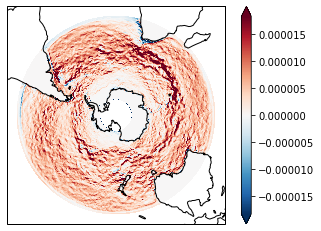

In [33]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
dsst_dy.plot(ax=ax, robust=True, transform=ccrs.PlateCarree())
ax.coastlines()

The meridional gradient is positive over the whole domain (temperature is increasing towards the equator), as might be expected. The stronges gradient is associated with the boundary between the retroflection of the warm [Agulhas current](https://en.wikipedia.org/wiki/Agulhas_Current) and the cold waters of the [Antarctic Circumpolar Current](https://en.wikipedia.org/wiki/Antarctic_Circumpolar_Current) in the Indian Ocean sector.